<a href="https://colab.research.google.com/github/Greg-Vincent0711/Learning-Pytorch/blob/main/04_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


In [41]:
# setting up training data
train_data = datasets.FashionMNIST(
    root="data", # where data is being downloaded
    train=True, # get training split
    download=True,
    # images need to be tensors to work with a model
    transform=ToTensor(),
    # don't transform labels
    target_transform=None
)

# setting up testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get testing split
    download=True,
    transform=ToTensor(),
    target_transform=None
)



In [42]:
train_classes = train_data.classes
test_classes = test_data.classes

Text(0.5, 1.0, 'Ankle boot')

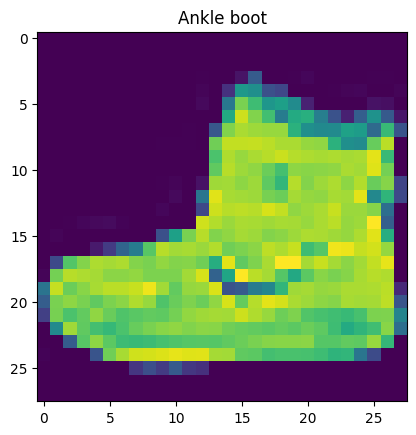

In [43]:
image, label = train_data[0]
# plt expects height and width, no color channel
plt.imshow(image.squeeze())
plt.title(train_classes[label])

(-0.5, 27.5, 27.5, -0.5)

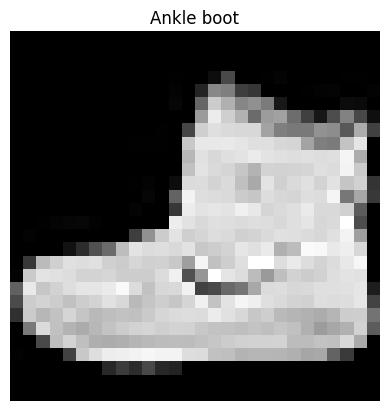

In [44]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(train_classes[label])
plt.axis(False)

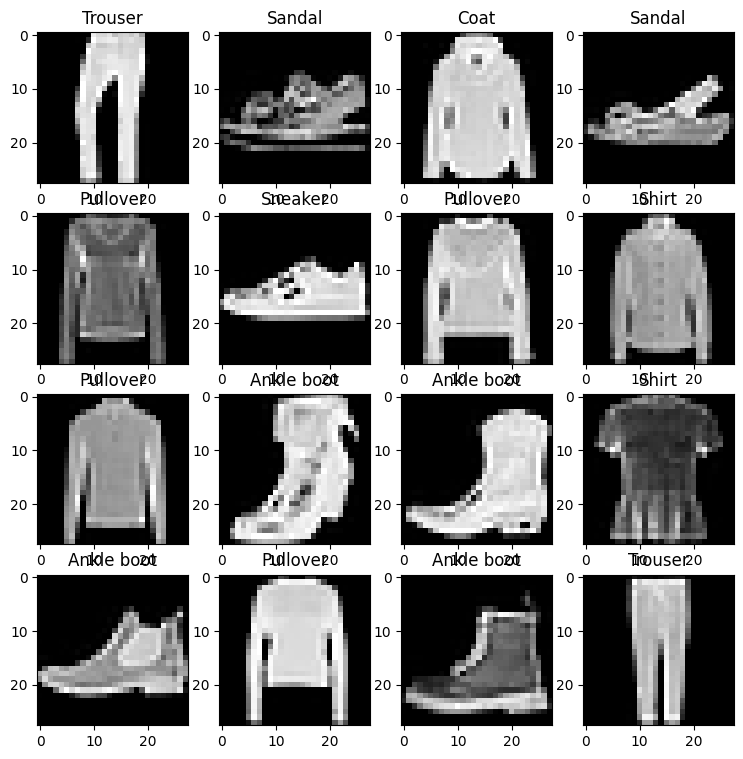

In [45]:
# just getting an idea of what the data looks like
fig = plt.figure(figsize=(9, 9))
rows, cols = 4,4
for i in range(1, rows * cols+1):
  random_index = torch.randint(0, len(train_data), size=[1]).item()
  image, label = train_data[random_index]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap="gray")
  plt.title(train_classes[label])


In [46]:
# preparing a dataloader
# dataset -> dataloader(turns data into a python iterable )
from torch.utils.data import DataLoader
BATCH_SIZE = 32
# shuffle training data so model doesn't learn img order
dataLoader_Train = DataLoader(train_data, BATCH_SIZE, True)
# shuffle doesn't matter for testing
dataLoader_Test = DataLoader(test_data, BATCH_SIZE, False)

Text(0.5, 1.0, 'T-shirt/top')

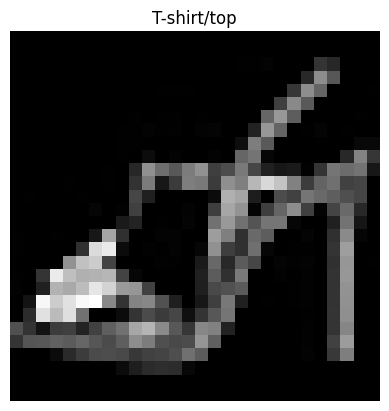

In [47]:
# interacting with a dataloader
train_features_batch, train_labels_batch = next(iter(dataLoader_Train))
plt.imshow(train_features_batch[0].squeeze(), cmap="gray")
plt.axis(False)
plt.title(train_classes[0])


In [48]:
# Creating a model

# Flatten reduces dims for inputs. Less complex and compatible with
# a fully connected layer
x = train_features_batch[0]
flatten_model = nn.Flatten()
output = flatten_model(x)
# flattening condenses the data into a single vector space
output[0][:5], x[0][:1]

(tensor([0., 0., 0., 0., 0.]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]]))

In [49]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self, input_shape:int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        # reduce dims of input
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape))
  def forward(self, input):
    return self.layer_stack(input)


In [50]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    # refers to shape of input data
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(train_classes)
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [51]:
def calculateAccuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  return (correct / len(y_pred)) * 100

In [52]:
# setting up a loss, optimizer and evaluation metrics

# we're using multi-class data, so loss fn is CrossEntropy
# optimizer is still SGD
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [53]:
# fn to track model speed
from timeit import default_timer as timer
def print_training_time(startTime:float,
                        endTime:float,
                        device:torch.device = None):
  runTime = endTime - startTime
  print(f"Training time for {device}:{runTime:.3f} seconds ")
  return runTime


In [54]:
# training/testing model
# for now, I'm writing both loops out to practice, but will functionize
torch.manual_seed(42)
# start timer on run
cpuStartTime = timer()
# lower epochs = faster training time
epochs = 3
for epoch in range((epochs)):
  print(f"Epoch # {epoch}")
  train_loss = 0
  # loop through training batches
  for batch, (train_image, label) in enumerate(dataLoader_Train):
    model_0.train()
    # create training predictions
    image_training_preds = model_0(train_image)
    # calculate loss and accuracy
    lossamnt = loss(image_training_preds, label)
    train_loss += lossamnt
    # zero optimizer, backprop, update weights with optimizer step
    optimizer.zero_grad()
    lossamnt.backward()
    optimizer.step()

  # avg out training loss over all
  train_loss /= len(dataLoader_Train)

  test_loss, test_acc = 0,0
  model_0.eval()
  # no gradient tracking for a performance boost
  with torch.inference_mode():
    for test_image, label in dataLoader_Test:
        image_testing_preds = model_0(test_image)
        test_loss += loss(image_testing_preds, label)
        # use argmax because chosen pred is based on max of probabilites
        # passing that in over logits. dim=1 refers to column values in a row
        test_acc += calculateAccuracy(label, image_testing_preds.argmax(dim=1))
    # avg test loss and acc per batch
    test_loss /= len(dataLoader_Test)
    test_acc /= len(dataLoader_Test)
  print(f"\n Train Loss {train_loss:.4f} | Test Loss: {test_loss:4f}, Test Acc: {test_acc:4f}")

# find training time
cpuEndTime = timer()
trainTime_model_0 = print_training_time(cpuStartTime,
                                        cpuEndTime,
                                        str(next(model_0.parameters()).device))

Epoch # 0

 Train Loss 0.5904 | Test Loss: 0.509535, Test Acc: 82.038738
Epoch # 1

 Train Loss 0.4763 | Test Loss: 0.479890, Test Acc: 83.196885
Epoch # 2

 Train Loss 0.4550 | Test Loss: 0.476639, Test Acc: 83.426518
Training time for cpu:26.371 seconds 


In [55]:
# functionalizing testing loop
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = None):
  loss, acc = 0,0
  model.eval()
  with torch.inference_mode():
    for image, label in data_loader:
      image,label = image.to(device),label.to(device)
      model_preds = model(image)
      # accumulating loss/acc values per batch
      loss += loss_fn(model_preds, label)
      acc += accuracy_fn(label, model_preds.argmax(dim=1))
    # find avg loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)
    return {
        "model_name": model.__class__.__name__,
        "model_test_loss": loss.item(),
        "model_test_acc": acc
        }

model_0_results = eval_model(model_0,
                             dataLoader_Test,
                             loss,
                             calculateAccuracy)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_test_loss': 0.47663894295692444,
 'model_test_acc': 83.42651757188499}

In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# designing a device agnostic model with non-linearity
class FashionMNISTModelV1(nn.Module):
  def __init__(self, input_shape:int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        # reduce input to a single vector
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()
        )
  def forward(self, input):
    return self.layer_stack(input)

In [57]:
# model is made with random numbers
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
                              hidden_units=10,
                              output_shape=len(test_classes)).to(device)
next(model_1.parameters()).device


device(type='cuda', index=0)

In [58]:
m1Loss = nn.CrossEntropyLoss()
m1Optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

# functionizing training loop

def train_model(model:torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  train_loss, train_acc = 0,0
  model.train()
  for batch, (train_image, label) in enumerate(data_loader):
    train_image, label = train_image.to(device), label.to(device)
    # create training predictions
    image_training_preds = model(train_image)
    # calculate loss and accuracy
    loss = loss_fn(image_training_preds, label)
    train_loss += loss
    train_acc += accuracy_fn(label, image_training_preds.argmax(dim=1))
    # zero optimizer, backprop, update weights with optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # avg out training loss over all
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  return {
    "model_name": model.__class__.__name__,
    "train_loss": train_loss,
    "train_acc": train_acc
  }

In [64]:
from timeit import default_timer as timer
gpuTimeStart = timer()
epochs = 3
for epoch in range((epochs)):
  train_model(model_1,
              dataLoader_Train,
              m1Loss,
              m1Optimizer,
              calculateAccuracy,
              device)
  eval_model(model_1,
             dataLoader_Test,
             m1Loss,
             calculateAccuracy,
             device)
gpuTimeEnd = timer()
gpuTrainTime = print_training_time(gpuTimeStart,
                        gpuTimeEnd,
                        str(next(model_1.parameters()).device))



Training time for cuda:0:29.544 seconds 


In [65]:
model_1_results = eval_model(model_1,
             dataLoader_Test,
             m1Loss,
             calculateAccuracy,
             device)
model_0_results, model_1_results

({'model_name': 'FashionMNISTModelV0',
  'model_test_loss': 0.47663894295692444,
  'model_test_acc': 83.42651757188499},
 {'model_name': 'FashionMNISTModelV1',
  'model_test_loss': 0.6956347227096558,
  'model_test_acc': 74.66054313099042})